# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [204]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import os
import pandas as pd

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [205]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = 'C:\\Users\\Daniel\\Desktop\\HW4Data\\Version4\\Release4\\interp_monthly\\SSHDYN'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [206]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
file_1992 = 'C:\\Users\\Daniel\\Desktop\\HW4Data\\Version4\\Release4\\interp_monthly\\SSHDYN\\SSHDYN_1992_01.nc'
file_2017 = 'C:\\Users\\Daniel\\Desktop\\HW4Data\\Version4\\Release4\\interp_monthly\\SSHDYN\\SSHDYN_2017_01.nc'

ds_1992 = xr.open_dataset(file_1992)
ds_2017 = xr.open_dataset(file_2017)

lon = ds_1992['longitude'].values
lat = ds_1992['latitude'].values
# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ssh_1992 = ds_1992['SSHDYN'].values
ssh_2017 = ds_2017['SSHDYN'].values

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

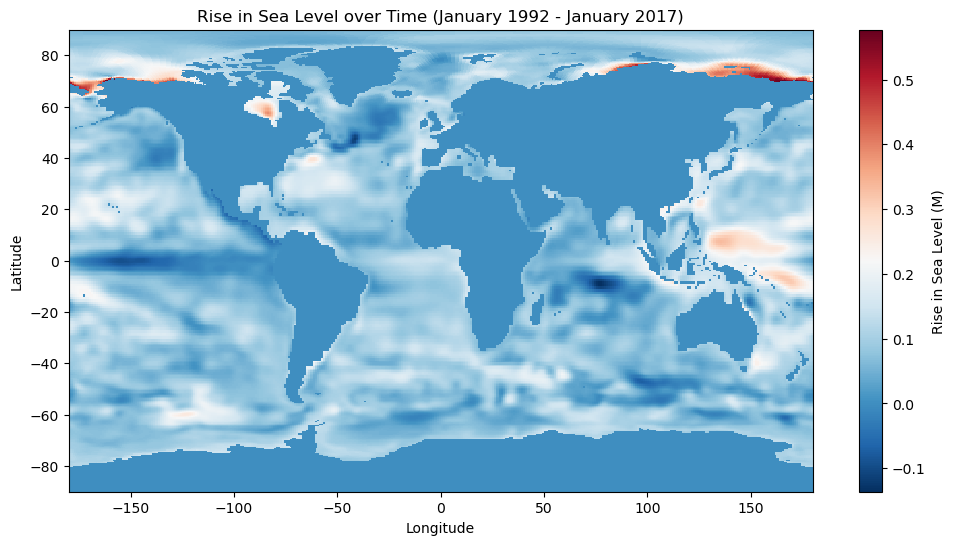

In [207]:
# make a plot of the differences between 2017 and 1992
ssh_diff = ssh_2017 - ssh_1992

plt.figure(figsize=(12, 6))
plt.pcolormesh(lon, lat, ssh_diff[0, :, :], cmap='RdBu_r', shading='auto')
plt.colorbar(label='Rise in Sea Level (M)')
plt.title('Rise in Sea Level over Time (January 1992 - January 2017)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest increases in sea level occur North of Alaska and Eastern Russia, as well as north of central Russia. There is also a noticeable increase east of the Philippines, and in Hudson Bay in Canada. The areas with the largest drop in sea level are in the central Atlantic, the Indian Ocean, and West/Northwest of Nova Scotia.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [208]:
new_lon = -122
new_lat = 37
lon_idx = np.argmin(np.abs(lon - new_lon))
lat_idx = np.argmin(np.abs(lat - new_lat))

print(f"Closest longitude index: {lon_idx}, Closest latitude index: {lat_idx}")

Closest longitude index: 115, Closest latitude index: 253


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

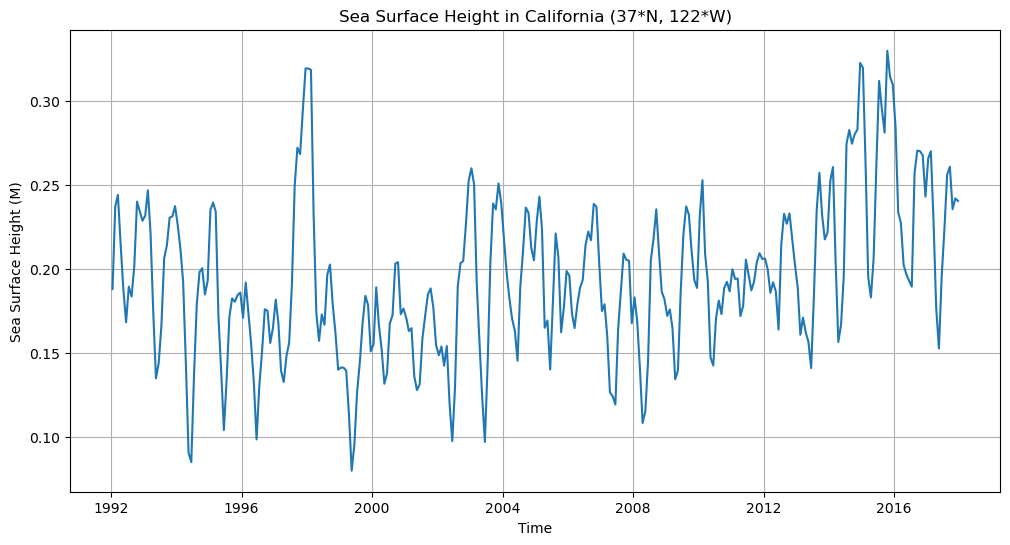

In [209]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

times = []
ssh_values = []

for file in ssh_files:
    ds = xr.open_dataset(file)
    time = pd.to_datetime(ds['time'].values[0])
    ssh = ds['SSHDYN'].values[0, lat_idx, lon_idx]
    times.append(time)
    ssh_values.append(ssh)

ssh_timeseries = pd.DataFrame({'Time': times, 'SSH': ssh_values})

plt.figure(figsize=(12, 6))
plt.plot(ssh_timeseries['Time'], ssh_timeseries['SSH'], linestyle='-')
plt.title('Sea Surface Height in California (37*N, 122*W)')
plt.xlabel('Time')
plt.ylabel('Sea Surface Height (M)')

plt.grid(True)
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

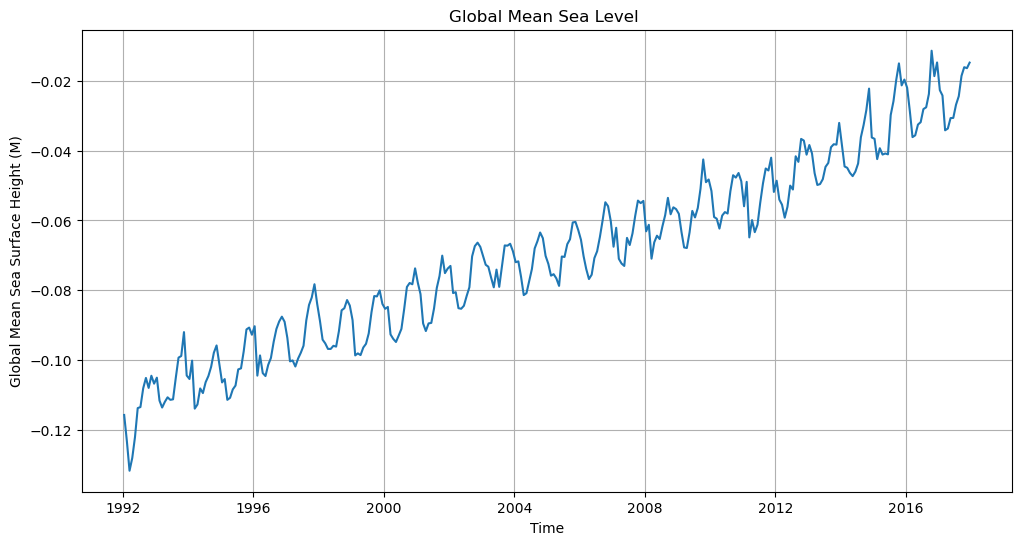

In [210]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
ssh_folder = 'C:\\Users\\Daniel\\Desktop\\HW4Data\\Version4\\Release4\\interp_monthly\\SSHDYN'


ssh_files = sorted([os.path.join(ssh_folder, f) for f in os.listdir(ssh_folder) if f.endswith('.nc')])
times = []
global_mean_ssh = []

for file in ssh_files:
    ds = xr.open_dataset(file)
    time = pd.to_datetime(ds['time'].values[0])
    ssh = ds['SSHDYN'].values[0, :, :]
    mean_ssh = np.mean(ssh[ssh != 0])  
    times.append(time)
    global_mean_ssh.append(mean_ssh)

plt.figure(figsize=(12, 6))
plt.plot(global_ssh_timeseries['Time'], global_ssh_timeseries['Global Mean SSH'], linestyle='-')
plt.title('Global Mean Sea Level ')
plt.xlabel('Time')
plt.ylabel('Global Mean Sea Surface Height (M)')
plt.grid(True)
plt.show()

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [211]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
ssh_timeseries['Time'] = pd.to_datetime(ssh_timeseries['Time'])  # Ensure time is in datetime format
years = ssh_timeseries['Time'].dt.year + (ssh_timeseries['Time'].dt.dayofyear / 365)
slope, intercept = np.polyfit(years, ssh_timeseries['SSH'], 1)
trend_line = slope * years + intercept

years_global = global_ssh_timeseries['Time'].dt.year + (global_ssh_timeseries['Time'].dt.dayofyear / 365)
slope_global, intercept_global = np.polyfit(years_global, global_ssh_timeseries['Global Mean SSH'], 1)
trend_line_global = slope_global * years_global + intercept_global

# print out the statistics in mm/yr for each timeseries
print(f"Average Annual Gain in Sea Level (California): {slope * 1000:.2f} mm/year")  
print(f"Average Annual Gain in Sea Level (Global): {slope_global * 1000:.2f} mm/year")  


Average Annual Gain in Sea Level (California): 2.08 mm/year
Average Annual Gain in Sea Level (Global): 3.38 mm/year


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The average sea level rise in California is moderately slower than the global mean rate, with a difference of 1.3 mm/year.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

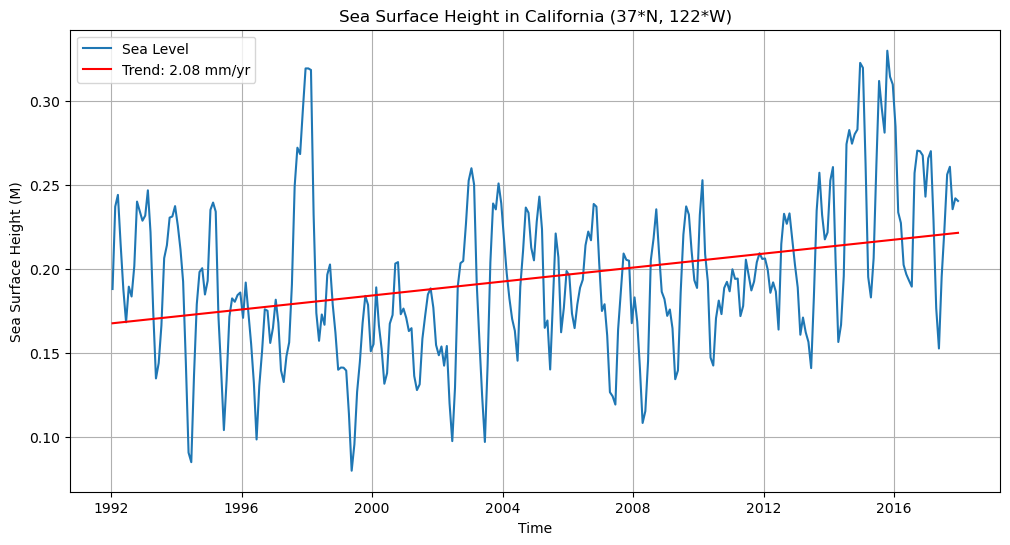

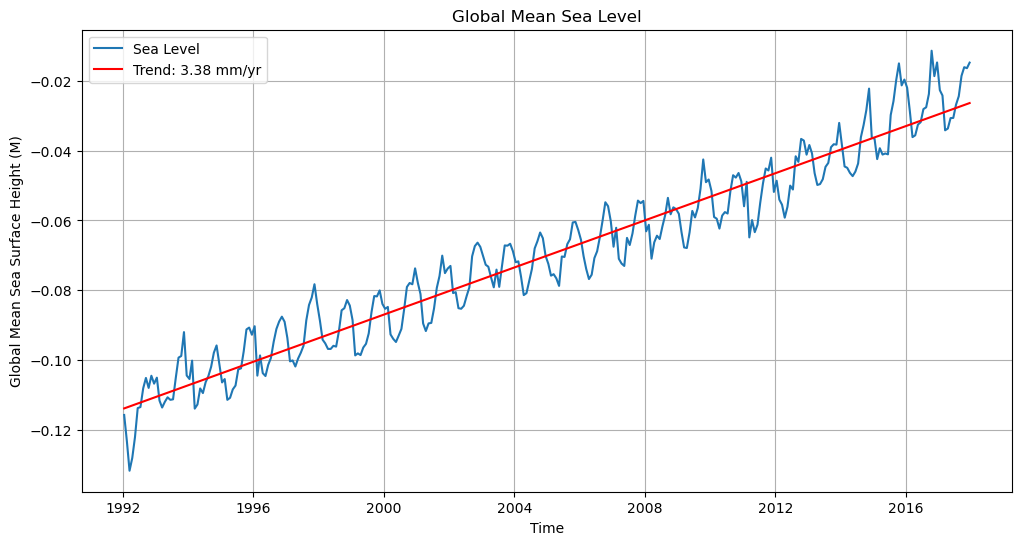

In [212]:
# create your plot here
plt.figure(figsize=(12, 6))
plt.plot(ssh_timeseries['Time'], ssh_timeseries['SSH'], label='Sea Level', linestyle='-')
plt.plot(ssh_timeseries['Time'], trend_line, label=f'Trend: {slope*1000:.2f} mm/yr', color='red')  

plt.title('Sea Surface Height in California (37*N, 122*W)')
plt.xlabel('Time')
plt.ylabel('Sea Surface Height (M)')
plt.legend()
plt.grid(True)
plt.show()


years_global = global_ssh_timeseries['Time'].dt.year + (global_ssh_timeseries['Time'].dt.dayofyear / 365)

slope_global, intercept_global = np.polyfit(years_global, global_ssh_timeseries['Global Mean SSH'], 1)
trend_line_global = slope_global * years_global + intercept_global


plt.figure(figsize=(12, 6))
plt.plot(global_ssh_timeseries['Time'], global_ssh_timeseries['Global Mean SSH'], label='Sea Level', linestyle='-')
plt.plot(global_ssh_timeseries['Time'], trend_line_global, label=f'Trend: {slope_global*1000:.2f} mm/yr', color='red')  

plt.title('Global Mean Sea Level')
plt.xlabel('Time')
plt.ylabel('Global Mean Sea Surface Height (M)')
plt.legend()
plt.grid(True)
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: The timeseries for California and the global mean show a slower gain in sea surface height in California. The global mean sea level has a faster gain in sea surface height. (California: 2.08 mm/year, (Globa): 3.38 mm/yea). It seems like there is more variablity in California's sea level, as it experiences more rapid and extreme fluctuations in the sea surface height, while the global mean sea level is more gradual, cyclic, and maintains the gains/losses every few years. The two highest years of sea level in California are 1997/1998 and 2015/2016. El Nino was active at those times and probably the reason for these spikes.r